# Assignment 2 - Eleanor Adachi

Our team's code can be found here: https://github.com/eleanor-adachi/ARE212_Materials

## 1. Exercises (Identifying Assumptions for Regression)

### (2) Suppose $y$, $x$ and $u$ are scalar random variables, with $y$ and $x$ observed but $u$ unobserved. Consider the function $h(x) = x^3$; under standard assumptions this satisfies our concerns about measurability, so $\mathbb{E}(u|x) = 0$ implies $\mathbb{E}(u x^3) = 0$. Use this last condition to motivate a simple least squares estimator of the regression equation $y = \alpha + \beta x + u$. How does this differ from the usual OLS estimator? Why might one prefer one to the other, and under what conditions?

$
y = \alpha + \beta x + u \\
(x^3) y = (x^3) \alpha + (x^3) \beta x + (x^3) u \\
y x^3  - \alpha x^3 - u x^3 =  \beta x^4 \\
(x^{-4}) y x^3  - (x^{-4}) \alpha x^3 - (x^{-4}) u x^3 =  \beta \\
b = \mathbb{E}((x^{-4}) y x^3)  - \mathbb{E}((x^{-4}) \alpha x^3) - \mathbb{E}((x^{-4}) u x^3)
$

Use $\mathbb{E}(u x^3) = 0$

$
\beta = \mathbb{E}((x^{-4}) y x^3)  - \mathbb{E}((x^{-4}) \alpha x^3) \\
\beta = \mathbb{E}(x^{-1} y)  - \alpha \mathbb{E}(x^{-1})
$

Switching to regression world

$
b= \frac{\overline{y} - a}{\overline{x}}
$

The usual OLS estimator is $b = (X^T X)^{-1} X^T Y$ or when $k=1$, $b = \frac{\sum_{i=1}^{n} (x_i - \overline{x})(y_i - \overline{y})}{\sum_{i=1}^{n} (x_i - \overline{x})^2}$

These two estimators lead to equivalent results. However, the estimator $b= \frac{\overline{y} - a}{\overline{x}}$ might be preferred if we have an estimate for $a$ since the computation is simpler. However, if we don't know $a$, then we would prefer the usual OLS estimator since it does not require any information about $a$.

## 2. Wright (1928)

Consider the canonical demand and supply model in which quantity supplied is a function of price and a set of "supply shifters"; quantity demanded is a function of price and set of "demand shifters"; and market clearing implies that at some price quantity demanded is equal to quantity supplied. A linear version of this model is fully specified and solved in [this Jupyter Notebook](https://github.com/ligonteaching/ARE212_Materials/blob/master/wright34.ipynb).

Consider the following questions:

1. (Control) What is the expected demand if we set the price $p = p_0$?

2. (Condition) What is the expected demand if we observe $p = p_0$?

3. (Counterfactual) If prices and quantities are observed to be $(p_0, q_0)$, what would demand be if we were to change the price to $p_1$, ceteris paribus?

Answers could be mathematical expressions, or code that answers the question for the model given in the Jupyter notebook.

### (1) (Control) What is the expected demand if we set the price $p = p_0$?

First, recreate the linear model in [wright34.ipynb](https://github.com/ligonteaching/ARE212_Materials/blob/master/wright34.ipynb) representing:

$$
   q_D = \alpha p + u\qquad q_S = \beta p + v\qquad q_D = q_S,
$$

where $u$ and $v$ have normal distributions of the form:

$F_u(u) = \frac{1}{\sigma \sqrt{2 \pi}} e^{−\frac{(u − \mu)^2}{2\sigma^2}}$

In [158]:
import numpy as np
import pandas as pd
from scipy.stats import distributions as iid

# Structural parameters;
(α,β) = (-1,2)     
σ = {'u':1/2,'v':1/3}
μ = {'u':2,'v':-1}

# u,v assumed independent
u = iid.norm(loc=μ['u'], scale=σ['u'])  # Demand shocks
v = iid.norm(loc=μ['v'], scale=σ['v'])  # Supply shocks

# Reduced form coefficients
π = [[-β/(α - β), -1/(α - β)],
     [ α/(α - β), 1/(α - β)]]

# Generate N realizations of system
# Outcomes Y have columns (q,p)
N = 10

# Arrange shocks into an Nx2 matrix
U = np.c_[u.rvs(N), v.rvs(N)]

# Matrix product gives [q,p]; label by putting into df
df = pd.DataFrame(U@π,columns=['q','p'])
Udf = pd.DataFrame(U,columns=['u','v']) # For future reference

First, visualize by plotting demand curve segments that intersect $p_0$ for different realizations of $u$.

Here, we show $p_0 = 1$.

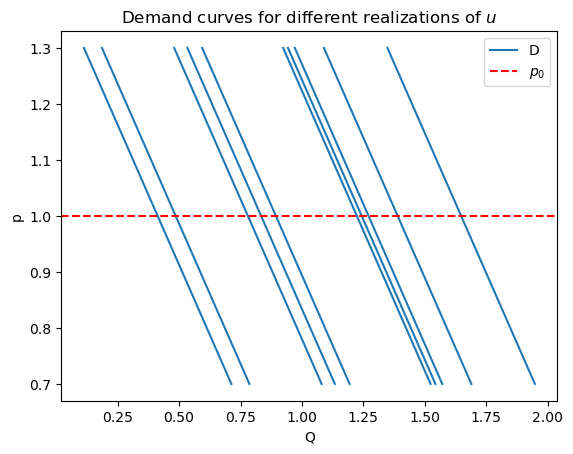

In [159]:
import matplotlib.pyplot as plt

p0 = 1

Q = pd.DataFrame({'min': α*(p0-0.3) + Udf['u'],
                  'max': α*(p0+0.3) + Udf['u'],
                  'miss':-1})

# Inverse counterfactual demand & supply (for plotting)
D = Q.add(-Udf['u'],axis=0)/α  

counterfactual=pd.DataFrame({'D':D.stack(),
                             'Q':Q.stack()})

counterfactual=counterfactual.replace(-1,np.nan)

_ = counterfactual.plot(x='Q')
plt.axhline(y = p0, color = 'r', linestyle = '--', label='$p_0$')
plt.ylabel('p')
plt.title('Demand curves for different realizations of $u$')
plt.legend()

Note that setting the price at $p = p_0$ has no effect on the distribution of $u$.

Show probability distribution function of $u$:

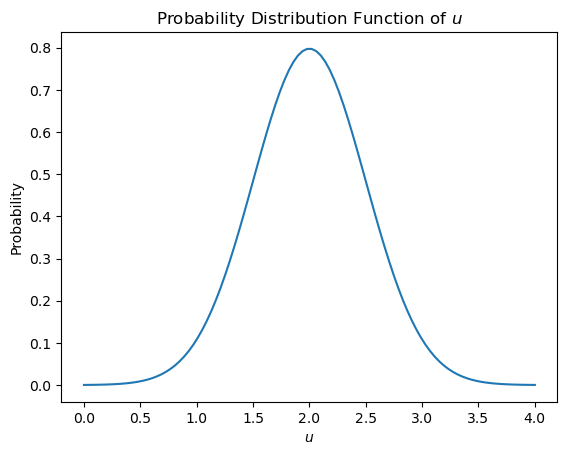

In [160]:
import numpy as np

X = np.linspace(0,4,100).tolist()

plt.plot(X, [u.pdf(z) for z in X])
plt.xlabel('$u$')
plt.ylabel('Probability')
plt.title('Probability Distribution Function of $u$')
plt.show()

Calculate expected demand:

$\mathbb{E}(q_D(p_0)) = \int_{}^{} q_D(p_0, u)dF_u(u)$

In [161]:
from scipy.integrate import quad

D_exp = quad(lambda x: (α*p0 + x)*u.pdf(x), -np.inf, np.inf)

D_exp

(1.0000000000000002, 3.5552369520475e-10)

### (2) (Condition) What is the expected demand if we observe $p = p_0$?

Note that many possible combinations of $u$ and $v$ can result in observing $p_0$.

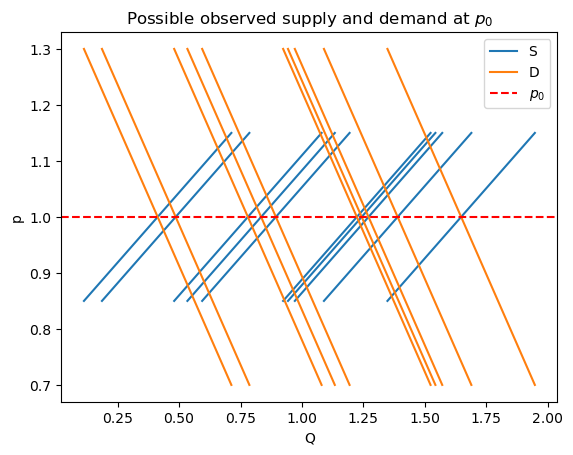

In [162]:
# Take u as given

# Find v such that p=p0 for given u
v0 = (α - β)*p0 + Udf['u']

Q = pd.DataFrame({'min': np.minimum(α*(p0-0.3) + Udf['u'], β*(p0+0.3) + v0),
                  'max': np.maximum(α*(p0+0.3) + Udf['u'], β*(p0-0.3) + v0),
                  'miss':-1})

# Inverse counterfactual demand & supply (for plotting)
D = Q.add(-Udf['u'],axis=0)/α  
S = Q.add(-v0,axis=0)/β

counterfactual=pd.DataFrame({'S':S.stack(),
                             'D':D.stack(),
                             'Q':Q.stack()})

counterfactual=counterfactual.replace(-1,np.nan)

_ = counterfactual.plot(x='Q')
plt.axhline(y = p0, color = 'r', linestyle = '--', label='$p_0$')
plt.ylabel('p')
plt.title('Possible observed supply and demand at $p_0$')
plt.legend()

Expected quantity demanded:

$\mathbb{E}[q^*(u,v) | q_D(p_0, u)=q_S(p_0, v)]$

When $q_S = q_D$, then $\alpha p + u = \beta p + v$

Let $v = u + (\alpha - \beta)p$

$f_{q^*}(u) = f_u(u) \cdot f_v(v)|\frac{\partial v}{\partial u}|$

$\mathbb{E}[q^*(u,v) | q_D(p_0, u)=q_S(p_0, v)] = \int_{}^{} q_D(p_0, u)dF_u(u)dF_v(u + (\alpha - \beta)p)$

In [163]:
# redefine q_D and v in terms of u
D_exp = quad(lambda x: (α*p0 + x)*u.pdf(x)*v.pdf(x + (α - β)*p0), -np.inf, np.inf)
D_exp

(0.6638800836636456, 1.0814326323877074e-08)

### (3) (Counterfactual) If prices and quantities are observed to be $(p_0, q_0)$, what would demand be if we were to change the price to $p_1$, ceteris paribus?

We can infer the value of $u_0$ at $(p_0, q_0)$

$$
u_0 = q_0 - \alpha p_0
$$

Then we can calculate:
$$
\Delta = q_D(p_1, u_0) - q_D(p_0, u_0)
$$

Let's use the first row of `df` as $(p_0, q_0)$ and let $p_1 = 1.1 p_0$

In [164]:
p0 = df['p'].iloc[0]
q0 = df['q'].iloc[0]

p1 = 1.1*p0

u0 = q0 - α*p0

delta = (α*p1 + u0) - (α*p0 + u0)

qd1 = q0 + delta

print(delta)

-0.09759891968724721


Text(0.5, 1.0, 'Effect of change in price on quantity demanded, ceteris paribus')

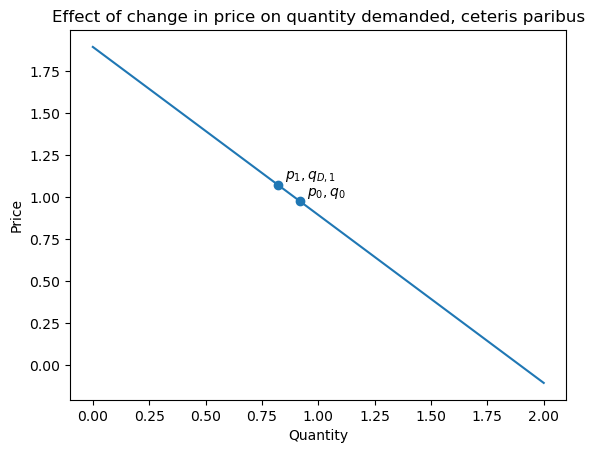

In [165]:
x = np.linspace(0, 2, 100).tolist()
y = [(q - u0)/α for q in x]
plt.plot(x, y)
plt.scatter([q0, qd1], [p0, p1])
label_offset = 0.03
plt.annotate('$p_0, q_0$', (q0+label_offset, p0+label_offset))
plt.annotate('$p_1, q_{D,1}$', (qd1+label_offset, p1+label_offset))
plt.xlabel('Quantity')
plt.ylabel('Price')
plt.title('Effect of change in price on quantity demanded, ceteris paribus')

## 4. Weak Instruments

This problem explores the problem of weak instruments. The basic setup should be familiar, with

$\begin{equation*}
y = \beta x + u \\
x = Z \pi + v
\label{eq:weak_instruments} \tag{3}
\end{equation*}$

Note that we’ve assumed that $x$ is a scalar random variable, and that $Z$ is an $\ell$-vector. (In general we might have $k$ endogenous $x$ variables, so long as we have $\ell > k$.)

### (1) Construct a data-generating process `dgp` which takes as arguments $(n, \beta, \pi)$ and returns a triple $(y, x, Z)$ of $n$ observations.

In [166]:
import numpy as np
import pandas as pd
from scipy.stats import distributions as iid

# NOTE: Don't need w anymore
# Unobservable component of instrument z
# Can have any distribution one pleases
w = iid.beta(1,2,loc=-iid.beta(1,2).mean()) # Centered for convenience

# Structural parameters;
sigma = {'u':1/2,'v':1/3}
mu = {'u':2,'v':-1}

# u,v assumed independent
u = iid.norm(loc=mu['u'], scale=sigma['u'])  # Demand shocks
v = iid.norm(loc=mu['v'], scale=sigma['v'])  # Supply shocks

def weak_dgp(n, beta, pi):
    """
    Generate data consistent with equations in Weak Instrument problem.

    Returns a tuple with numpy arrays y, x, and Z, all of length n
    """
    # Arrange u and v into matrix
    U = np.c_[u.rvs(n), v.rvs(n)]
    Udf = pd.DataFrame(U,columns=['u','v']) # For future reference
    
    # Relate Z to v
    # Let l = 1
#     unobserved_shock = w.rvs(n)/10
#     Z = (1-unobserved_shock)*np.exp(4*Udf['v'] - unobserved_shock)
    
    # Neri: Generate Z as an l-vector
    Z = np.random.normal(size=n)
    
    # Construct x
    x = Z*pi + v.rvs(n)
#     x = Z@pi + v.rvs(n) # if l > 1
    
    # Construct y
    y = beta*x + u.rvs(n)
    
    # Store in DataFrame
    df = pd.DataFrame(columns=['y', 'x', 'Z'])
    df['y'] = y
    df['x'] = x
    df['Z'] = Z # note, this works because l = 1
    return df[['y']], df[['x']], df[['Z']]

In [167]:
np.random.seed(1234)

beta = -1
pi = 2  
y, x, Z =  weak_dgp(10000, beta, pi)

[[1.98994504]]


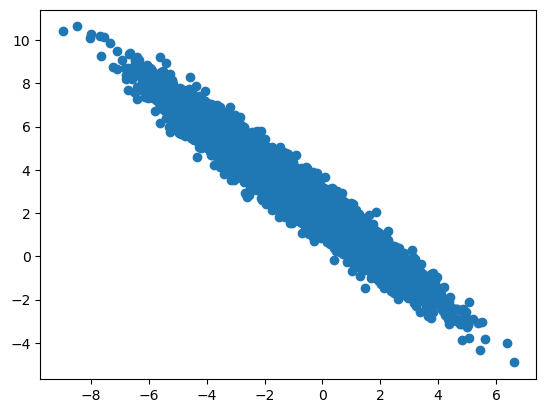

In [168]:
# TO DO: Why is pi_hat negative when x and Z have a positive relationship??

pi_hat = np.linalg.solve(Z.T@Z,Z.T@x)
print(pi_hat)

plt.scatter(x, y)


### (2) Use the `dgp` function you’ve constructed to explore IV (2SLS) estimates of $\beta$ as a function of $\pi$ when $\ell = 1$ using a Monte Carlo approach, assuming homoskedastic errors.

#### (a) Write a function `two_sls` which takes as arguments $(y, x, Z)$ and returns two-stage least squares estimates of $\beta$ and the standard error of the estimate.

$$
\begin{equation*}
y = \beta x + u \\
x = Z \pi + v
\label{eq:weak_instruments} \tag{3}
\end{equation*}
$$

In [169]:
from scipy.linalg import inv

def two_sls(y, x, Z):
    '''Takes y, x, and Z and returns a two-stage least squares estimates of beta and its standard error'''
    # first stage, regress x on Z
    pi_hat = np.linalg.solve(Z.T@Z,Z.T@x)
#     pi_hat = -1*np.linalg.solve(Z.T@Z,Z.T@x) # need to multiply by -1 for some reason??
    x_hat = Z@pi_hat
    
    # second stage, regress y on x-hat
    b = np.linalg.solve(x_hat.T@x_hat, x_hat.T@y)
    
    # compute standard error
    xb_df = x@b
    xb_df = xb_df.rename(columns={0:'y'})
    e = y - xb_df
    s2 = (e.T@e)/(len(y)-1)
#     vb = e.var().iloc[0]*inv(x_hat.T@x_hat) # why so different??
    vb = s2*inv(x_hat.T@x_hat) # matches Anna's code
    seb = np.sqrt(np.diag(vb))
    
    # Store in DataFrame
    df = pd.DataFrame(columns=['b', 'seb'])
    df['b'] = b[0]
    df['seb'] = seb
    return df[['b']], df[['seb']]

b, seb = two_sls(y, x, Z)
print(b)
print(seb)

          b
0 -0.994699
        seb
0  0.010428


#### (b) Taking $\beta = \pi = 1$, use repeated draws from `dgp` to check the bias, and precision of the `two_sls` estimator, as well as the size and power of a $t$-test of the hypothesis that $\beta = 0$. Discuss. Does a 95% confidence interval (based on your 2SLS estimator) correctly cover 95% of your Monte Carlo draws?

Helpful: https://pages.uoregon.edu/waddell/metrics/ols-in-review.html

Helpful: https://derekogle.com/NCMTH107/modules/Explanations/Calc_Beta

Helpful: https://stackoverflow.com/questions/54067722/calculate-power-for-t-test-in-python

In [170]:
np.random.seed(1234)

def simulator(N, n, beta, pi, dgp):
    """
    Perform N draws of sample size n with parameters beta and pi.
    """
    results = pd.DataFrame(columns=['b', 'seb'])
    for i in range(N):
        y, x, Z =  dgp(n, beta, pi)
        b, seb = two_sls(y, x, Z)
        results0 = pd.concat([b, seb], axis=1)
        if results.empty:
            results = results0.copy()
        else:
            results = pd.concat([results, results0], axis=0)

    return results

beta = 1
pi = 1
N = 1000
results = simulator(N, 10000, beta, pi, weak_dgp)

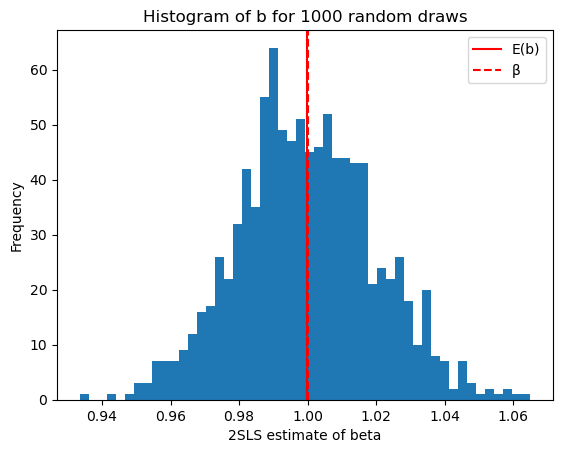

In [171]:
b_avg = results['b'].mean()

plt.hist(results['b'], bins=50)
plt.axvline(x=b_avg, color='r', label='E(b)')
plt.axvline(x=beta, color='r', linestyle='--', label='β')
plt.xlabel('2SLS estimate of beta')
plt.ylabel('Frequency')
plt.title('Histogram of b for {} random draws'.format(N))
plt.legend()

In [172]:
# more formally

bias = results['b'].mean() - beta
var = np.sum(np.square(results['b'] - results['b'].mean()))
sd = np.sqrt(var)
se = sd/np.sqrt(len(results))

print('Bias: ', bias)
print('Standard error (precision): ', se)

Bias:  -0.0002515036921023617
Standard error (precision):  0.020054355607954908


See bias and variance for the 2SLS estimator of $\beta$ calculated above. The expected value of $b$ for many random draws is about -1.7 even though the true value of $\beta$ is -1.

In [173]:
from scipy.stats import t
import statsmodels.stats.power as smp

# Size of two-tailed t-test for beta = 0
t_score = (b_avg - 0)/se
n = len(results)
df = n - 1
pval = t.sf(np.abs(t_score), df) * 2
print('Size: ', pval) # 0.002459484853055268

# Power of two-tailed t-test for beta = 0
alpha = 0.05
delta = b_avg - 0
effect_size = np.abs(delta/sd)
power = smp.ttest_power(effect_size, nobs=n, alpha=alpha, alternative='two-sided')
print('Power: ', power) # 0.8583924597539527

Size:  2.997363939588163e-273
Power:  1.0


The p-value or size of this test, i.e. the probability that the null hypothesis is true, is 0.0025, which is less than 0.05. Therefore we reject the null hypothesis that $\beta = 0$.

The power of the test is the probability that the null hypothesis is false, i.e., that rejecting the null hypothesis is the right decision. In this case, the probability is about 86%.

In [174]:
# Does a 95% confidence interval (based on your 2SLS estimator) correctly cover 95% of your Monte Carlo draws?

ci = t.interval(confidence=0.95, df=df, loc=b_avg, scale=se)
print(ci)

mc_95 = np.quantile(results['b'], 0.025), np.quantile(results['b'], 0.975)
print(mc_95)

(0.9603950028220937, 1.0391019897937017)
(0.9613482519200512, 1.0391460331194302)


Yes, 95% of the Monte Carlo draws are within the 95% confidence interval.

#### (c) Taking $\beta = 1$, but allowing $\pi \in [0, 1]$ again evaluate the bias and precision of the estimator, and the size and power of a $t$-test. The $Z$ instrument is "weak" when $\pi$ is "close" to zero. Comment on how a weak instrument affects two-stage least squares estimators.

As shown below, when $Z$ is a weak instrument--i.e., when $\pi$ is close to 0--then the bias of the 2SLS estimator becomes increasingly large. The standard error of the estimator also tends to increase.

In [175]:
beta = 1
pi_ls = [1, 0.1, 0.01]

results_dict = {}
for pi in pi_ls:
    results = simulator(N, 10000, beta, pi, weak_dgp)
    results_dict[pi] = results

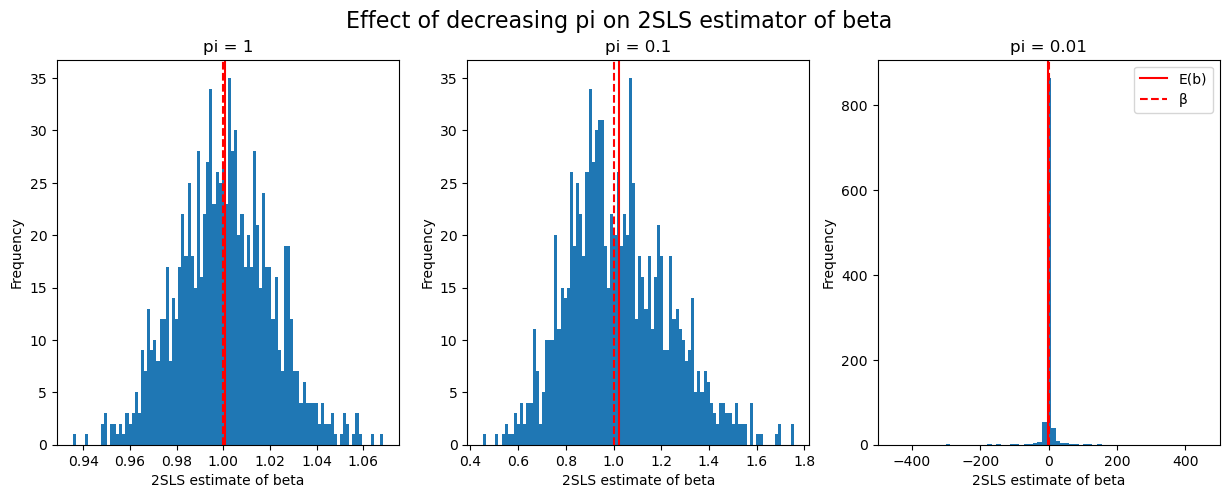

In [176]:
fig, axs = plt.subplots(1, len(pi_ls), figsize=(15, 5))
fig.suptitle('Effect of decreasing pi on 2SLS estimator of beta', fontsize=16)
for i in range(len(pi_ls)):
    pi = pi_ls[i]
    results = results_dict[pi]
    axs[i].hist(results['b'], bins=100)
    axs[i].axvline(x=results['b'].mean(), color='r', label='E(b)')
    axs[i].axvline(x=beta, color='r', linestyle='--', label='β')
    if pi == 0.01:
        axs[i].set_xlim([-500, 500])
    axs[i].set_xlabel('2SLS estimate of beta')
    axs[i].set_ylabel('Frequency')
    axs[i].title.set_text('pi = '+str(pi))
plt.legend()
plt.show()

In [177]:
# pi = 0.1

results = results_dict[0.1]

b_avg = results['b'].mean()
bias = results['b'].mean() - beta
var = np.sum(np.square(results['b'] - results['b'].mean()))
sd = np.sqrt(var)
se = sd/np.sqrt(len(results))

print('Bias: ', bias)
print('Standard error (precision): ', se)

# Size of two-tailed t-test for beta = 0
t_score = (b_avg - 0)/se
n = len(results)
df = n - 1
pval = t.sf(np.abs(t_score), df) * 2
print('Size: ', pval)

# Power of two-tailed t-test for beta = 0
alpha = 0.05
delta = b_avg - 0
effect_size = np.abs(delta/sd)
power = smp.ttest_power(effect_size, nobs=n, alpha=alpha, alternative='two-sided')
print('Power: ', power)

Bias:  0.02075960248848019
Standard error (precision):  0.2123173682078075
Size:  1.761282661798254e-06
Power:  0.9977662434148524


In [178]:
# pi = 0.01

results = results_dict[0.01]

b_avg = results['b'].mean()
bias = results['b'].mean() - beta
var = np.sum(np.square(results['b'] - results['b'].mean()))
sd = np.sqrt(var)
se = sd/np.sqrt(len(results))

print('Bias: ', bias)
print('Standard error (precision): ', se)

# Size of two-tailed t-test for beta = 0
t_score = (b_avg - 0)/se
n = len(results)
df = n - 1
pval = t.sf(np.abs(t_score), df) * 2
print('Size: ', pval)

# Power of two-tailed t-test for beta = 0
alpha = 0.05
delta = b_avg - 0
effect_size = np.abs(delta/sd)
power = smp.ttest_power(effect_size, nobs=n, alpha=alpha, alternative='two-sided')
print('Power: ', power)

Bias:  -1.35350484479041
Standard error (precision):  39.3122047990799
Size:  0.9928271212588816
Power:  0.050009244837735126


### (3) Now consider another "weak" instruments problem. Consider the sequence $\{1, 1/2, 1/4, 1/8, . . . \}$. Let $\ell = 1, 2, 3, . . .$, and for a particular value of $\ell$ let the vector of parameters $\pi_\ell$ consist of the first $\ell$ elements of the sequence. Thus, your `dgp` should now return $Z$ we can treat as an $n \times \ell$ matrix, with successive columns of $Z$ increasingly "weak" instruments.

#### (a) Taking $\beta = 1$, but allow $\ell$ to increase $(\ell = 1, 2, ...)$. Note that for $\ell > 1$ this is now an "overidentified" estimator. Describe the bias and precision of the estimator, and the size and power of a $t$-test. Compare with the case of $\ell = 1$ and $\pi = 1$.

See below for bias and precision of the 2SLS estimator and the size and power of a $t$-test as $\ell$ increases.

Compared to $\ell = 1$ and $\pi = 1$, the bias, standard error (precision), and p-value (size) of the $t$-test is smaller when $\ell = 2$ or $\ell = 3$. In addition, the power of the $t$-test is larger. However, as discussed in part (b), these trends reverse when $\ell > 3$.

In [179]:
# NOTE: Don't need w anymore
# Unobservable component of instrument z
# Can have any distribution one pleases
# w = iid.beta(1,2,loc=-iid.beta(1,2).mean()) # Centered for convenience

# Structural parameters;
sigma = {'u':1/2,'v':1/3}
mu = {'u':2,'v':-1}

# u,v assumed independent
u = iid.norm(loc=mu['u'], scale=sigma['u'])  # Demand shocks
v = iid.norm(loc=mu['v'], scale=sigma['v'])  # Supply shocks

def seq_dgp(n, beta, ell):
    """
    Generate data consistent with equations in Weak Instrument problem with the sequence 1, 1/2, 1/4, 1/8, ...

    Returns a tuple with numpy arrays y, x, and Z, all of length n
    """
    # Arrange u and v into matrix
    U = np.c_[u.rvs(n), v.rvs(n)]
    Udf = pd.DataFrame(U,columns=['u','v']) # For future reference
    
    # Relate Z to v, let l = 1
#     unobserved_shock = w.rvs(n)/10
#     Z_ls = []
#     for j in range(ell):
#         Z_j = (1+unobserved_shock**j)*np.exp(4*Udf['v'] - j*unobserved_shock)
#         Z_ls.append(Z_j)
#     Z = np.array(Z_ls).T
    
    # Use normal distribution for Z
    Z_ls = []
    for j in range(ell):
        Z_j = np.random.normal(loc=j, scale=0.1*(j+1), size=n)
        Z_ls.append(Z_j)
    Z = np.array(Z_ls).T
    
    # Construct pi
    pi = np.exp2(np.arange(0, -1*ell, -1))
    
    # Construct x
    x = Z@pi + v.rvs(n) # if l > 1
    
    # Construct y
    y = beta*x + u.rvs(n)
    
    # Store in DataFrame
    df = pd.DataFrame(columns=['y', 'x', 'Z'])
    df['y'] = y
    df['x'] = x
    df['Z'] = Z # note, this works because l = 1
    return df[['y']], df[['x']], df[['Z']]

In [180]:
from scipy.linalg import inv

np.random.seed(1234)

def two_sls(y, x, Z):
    '''Takes y, x, and Z and returns a two-stage least squares estimates of beta and its standard error'''
    # first stage, regress x on Z
    # now overidentified
    pi_hat = np.linalg.lstsq(Z.T@Z,Z.T@x,rcond=None)[0]
    x_hat = Z@pi_hat
    
    # second stage, regress y on x-hat
    b = np.linalg.solve(x_hat.T@x_hat, x_hat.T@y)
    
    # compute standard error
    xb_df = x@b
    xb_df = xb_df.rename(columns={0:'y'})
    e = y - xb_df
    s2 = (e.T@e)/(len(y)-1)
#     vb = e.var().iloc[0]*inv(x_hat.T@x_hat) # why so different??
    vb = s2*inv(x_hat.T@x_hat) # matches Anna's code
    seb = np.sqrt(np.diag(vb))
    
    # Store in DataFrame
    df = pd.DataFrame(columns=['b', 'seb'])
    df['b'] = b[0]
    df['seb'] = seb
    return df[['b']], df[['seb']]

def seq_simulator(N, n, beta, ell, dgp):
    """
    Perform N draws of sample size n with parameters beta and ell.
    """
    results = pd.DataFrame(columns=['b', 'seb'])
    for i in range(N):
        y, x, Z =  dgp(n, beta, ell)
        b, seb = two_sls(y, x, Z)
        results0 = pd.concat([b, seb], axis=1)
        if results.empty:
            results = results0.copy()
        else:
            results = pd.concat([results, results0], axis=0)

    return results

beta = 1
ell = 1
N = 1000
results = seq_simulator(N, 10000, beta, ell, seq_dgp)

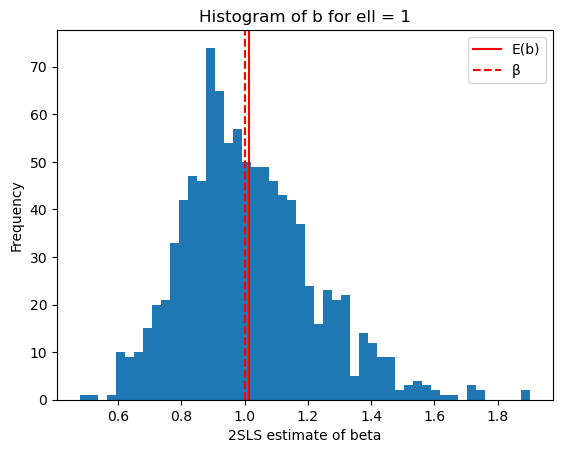

In [181]:
# histogram for ell = 1

b_avg = results['b'].mean()

plt.hist(results['b'], bins=50)
plt.axvline(x=b_avg, color='r', label='E(b)')
plt.axvline(x=beta, color='r', linestyle='--', label='β')
plt.xlabel('2SLS estimate of beta')
plt.ylabel('Frequency')
plt.title('Histogram of b for ell = 1')
plt.legend()

In [182]:
# generate results

np.random.seed(1234)
beta = 1
ell_ls = [1, 2, 3, 4, 5]

results_dict = {}
for ell in ell_ls:
    results = seq_simulator(N, 10000, beta, ell, seq_dgp)
    results_dict[ell] = results

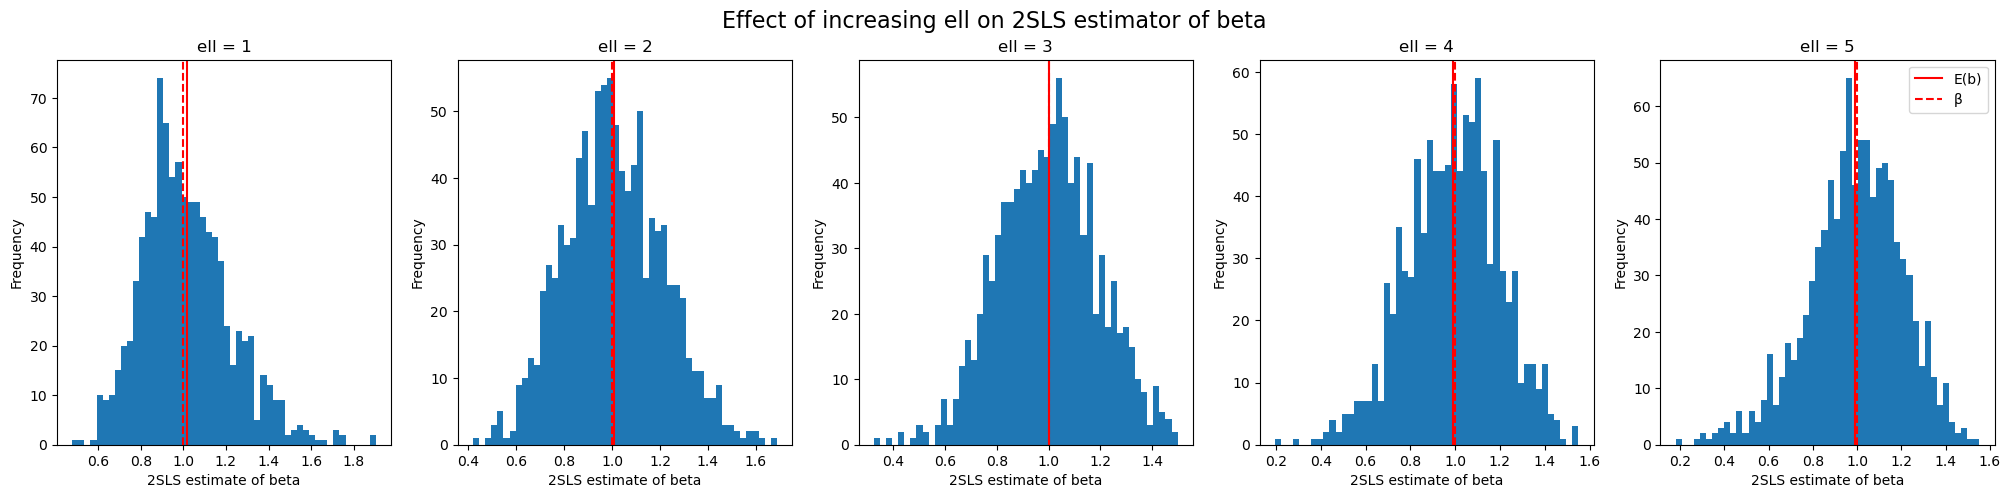

In [183]:
# plot results

fig, axs = plt.subplots(1, len(ell_ls), figsize=(5*len(ell_ls), 5))
fig.suptitle('Effect of increasing ell on 2SLS estimator of beta', fontsize=16)
for i in range(len(ell_ls)):
    ell = ell_ls[i]
    results = results_dict[ell]
    axs[i].hist(results['b'], bins=50)
    axs[i].axvline(x=results['b'].mean(), color='r', label='E(b)')
    axs[i].axvline(x=beta, color='r', linestyle='--', label='β')
#     axs[i].set_xlim([-200, 200])
    axs[i].set_xlabel('2SLS estimate of beta')
    axs[i].set_ylabel('Frequency')
    axs[i].title.set_text('ell = '+str(ell))
plt.legend()
plt.show()

In [184]:
# describe the bias and precision of the estimator, and the size and power of a t-test

def estimator_eval(results):
    b_avg = results['b'].mean()
    bias = results['b'].mean() - beta
    var = np.sum(np.square(results['b'] - results['b'].mean()))
    sd = np.sqrt(var)
    se = sd/np.sqrt(len(results))

    print('Bias: ', bias)
    print('Standard error (precision): ', se)

    # Size of two-tailed t-test for beta = 0
    t_score = (b_avg - 0)/se
    n = len(results)
    df = n - 1
    pval = t.sf(np.abs(t_score), df) * 2
    print('Size: ', pval)

    # Power of two-tailed t-test for beta = 0
    alpha = 0.05
    delta = b_avg - 0
    effect_size = np.abs(delta/sd)
    power = smp.ttest_power(effect_size, nobs=n, alpha=alpha, alternative='two-sided')
    print('Power: ', power)
    return bias, var, pval, power

for ell in ell_ls:
    print(ell)
    bias, var, pval, power = estimator_eval(results_dict[ell])

1
Bias:  0.01493729745527772
Standard error (precision):  0.20897737556360066
Size:  1.3848525034030897e-06
Power:  0.998086271585042
2
Bias:  0.007008104204763388
Standard error (precision):  0.20490383328653403
Size:  1.0395592930679765e-06
Power:  0.9984103257820925
3
Bias:  -0.0003695435936553748
Standard error (precision):  0.1924436798972205
Size:  2.488733073675605e-07
Power:  0.9993798119657347
4
Bias:  -0.00994334349187831
Standard error (precision):  0.20717280561749601
Size:  2.026865623530177e-06
Power:  0.9975560380615534
5
Bias:  -0.00919916354056638
Standard error (precision):  0.2134495315487597
Size:  3.912891998702194e-06
Power:  0.9962904114001835


#### (b) What can you say about the optimal number of instruments (choice of $\ell$) in this case?

In this case, it appears that the optimal number of instruments is 3 ($\ell = 3$). The bias, standard error (precision), and p-value (size) of the $t$-test is smallest and the power is the greatest when $\ell = 3$. At first, increasing $\ell$ tended to improve the bias and preicsion of the estimator. However, for $\ell > 3$, bias and precision increase as $\ell$ increases.